In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

In [2]:
# Construct the matrix
d = 7

# consider r_{k,m-k,-k} = a_k b_{m-k} c_{-k}

A = torch.zeros(d * d, 3 * d)
b = torch.zeros(d * d)

idx = 0
for k in range(d):
    for m in range(d):
        # if k == m == 0:
        #     continue
        A[idx, k] = 1
        A[idx, d + (m-k + d) % d] = 1
        A[idx, 2*d + (d - k) % d] = 1
        
        b[idx] = 1
        
        idx += 1
        
# Then compute its svd
U, D, V = torch.svd(A)

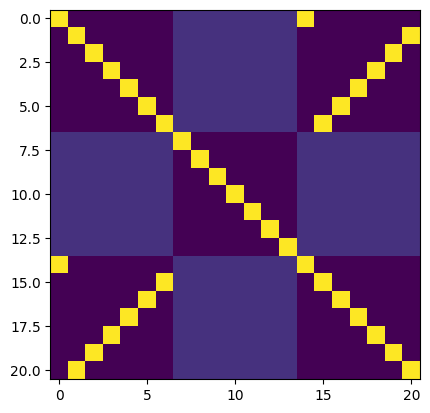

In [38]:
plt.imshow(A.t() @ A)

In [39]:
A.t()@A

tensor([[7., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 7., 0., 0., 0.,
         0., 0., 0.],
        [0., 7., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 7.],
        [0., 0., 7., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 7., 0.],
        [0., 0., 0., 7., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         7., 0., 0.],
        [0., 0., 0., 0., 7., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 7.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 7., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 7., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 7., 1., 1., 1., 1., 1., 1., 1., 0., 7., 0., 0.,
         0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 7., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 7., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 7., 0., 0., 0., 0., 1., 1., 

In [33]:
# simple dynamics

w = torch.rand(3 * d) + 0.01
nIter = 1000

alpha = 0.01

for t in range(nIter):
    # compute r
    r = torch.zeros(d * d)
    for i in range(A.shape[0]):
        r[i] = w[A[i,:] > 0.5].prod()
    deltaw = (A.t() @ r) / w
    w = w + alpha * deltaw
    
    w = w / w.norm()
    
    


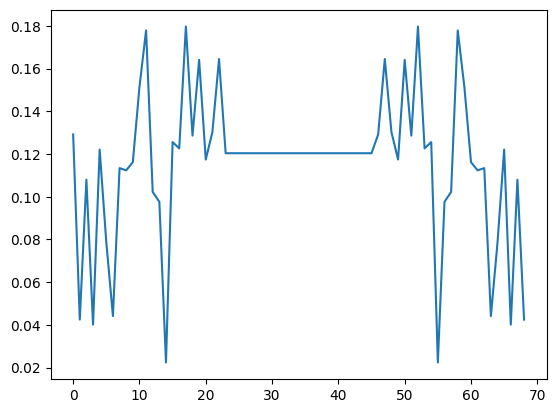

In [34]:
plt.plot(w)

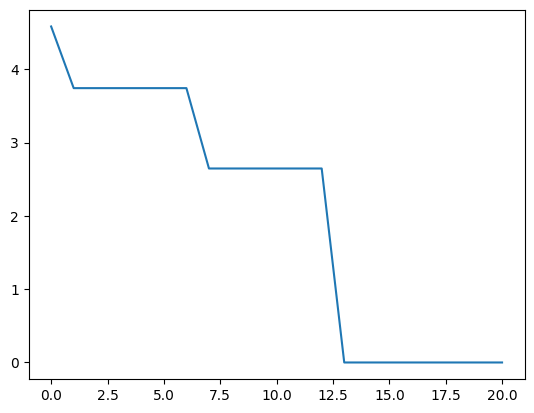

In [11]:
plt.plot(D)

In [12]:
D

tensor([4.5826e+00, 3.7417e+00, 3.7417e+00, 3.7417e+00, 3.7417e+00, 3.7417e+00,
        3.7417e+00, 2.6458e+00, 2.6458e+00, 2.6458e+00, 2.6458e+00, 2.6458e+00,
        2.6458e+00, 4.5116e-07, 3.5976e-07, 2.9977e-07, 1.9931e-07, 1.7179e-07,
        9.6054e-08, 5.0942e-08, 3.0720e-14])

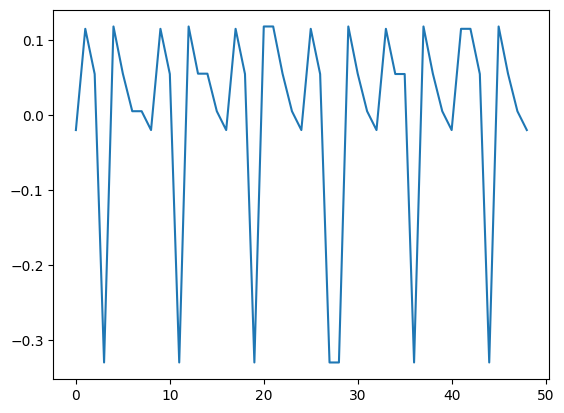

In [23]:
plt.plot(U[:,9])

In [47]:
# Construct the matrix
d = 7

# Consider r_{kkk} = a_k b_k c_k 

A = torch.zeros(d * d * d, 3 * d)
b = torch.zeros(d * d * d)

idx = 0
for k1 in range(d):
    for k2 in range(d):
        for k3 in range(d):
            A[idx, k1] = 1
            A[idx, d + k2] = 1
            A[idx, 2 * d + k3] = 1
            
            if k1 == k2 == k3:
                b[idx] = 1
            
            idx += 1

In [86]:
# more general dynamics
# r is of size d^2
q = 200
noise = 0.01
r = torch.randn(d * d * d, q, dtype=torch.cfloat) * noise
# Make each entry of r unit norm
r = r / r.abs()

print((b - r.sum(dim=1)).norm())

AAT = A @ A.t()
b = b.to(torch.cfloat)

nIter = 100

alpha = 0.001

errs = torch.zeros(nIter)

for t in range(nIter):
    # compute r
    r_sum = r.sum(dim=1)
    deltar = torch.zeros(d * d * d, q, dtype=torch.cfloat)
    for j in range(q):
        deltar[:,j] = (r[:,j][:,None] * AAT * r[:,j][None, :].conj()) @ (b - r_sum)

    errs[t] = (b - r_sum).norm()
    r = r + alpha * deltar
    # r = r / r.abs()

tensor(259.3648)


tensor(1.3033e-05)


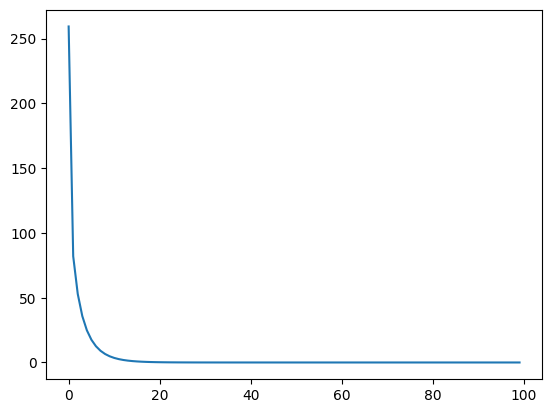

In [87]:
plt.plot(errs)
print(errs[-1])

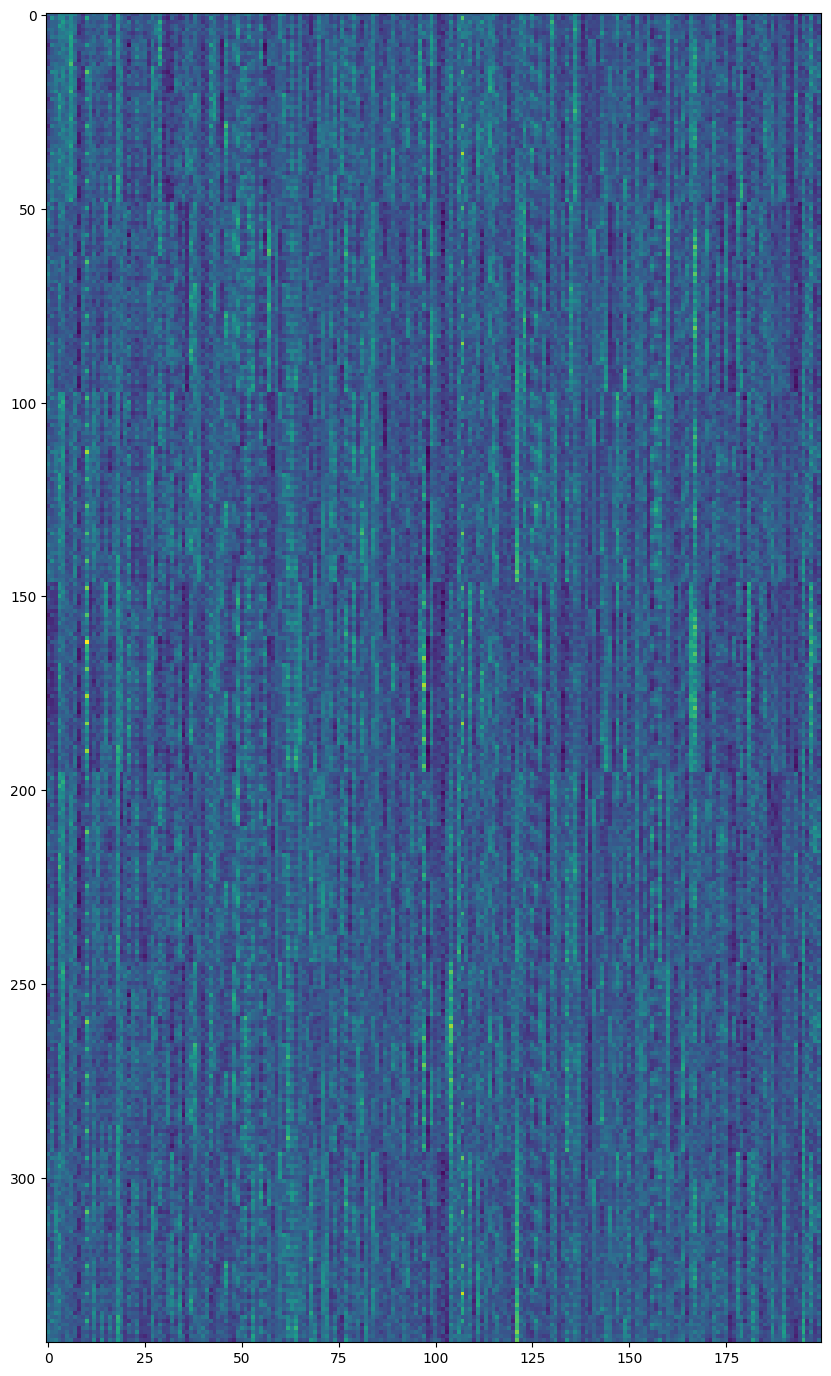

In [88]:
plt.figure(figsize=(10,20))
plt.imshow(r.abs())

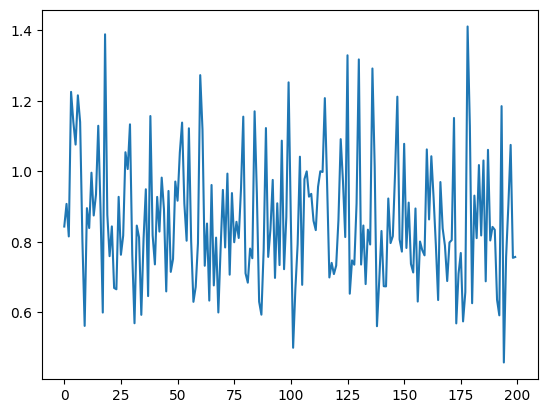

In [89]:
plt.plot(r.abs()[0])

In [71]:
all_one = torch.ones(d, d)
identity = torch.eye(d)

AAT_est = torch.kron(torch.kron(all_one, all_one), identity) + torch.kron(torch.kron(all_one, identity), all_one) + torch.kron(torch.kron(identity, all_one), all_one)

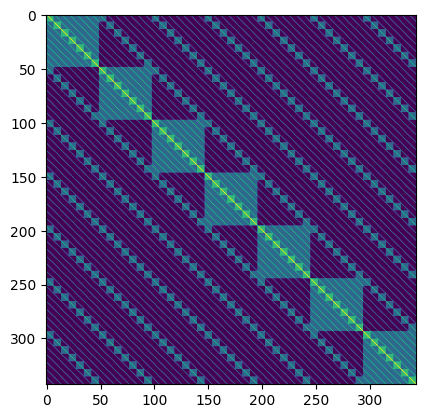

In [72]:
plt.imshow(AAT_est)

In [74]:
(AAT_est - AAT).norm()

tensor(0.)